# Introduction
> The below example showcases how you can utilise the FairML toolkit to extract feature dependence of your deployed model. In the below example we use a logistic regression model. You can however use any classifier or regressor

> In this example we will use a LightGBM model

> Documentation for this ToolKit can be found here: https://github.com/adebayoj/fairml

# Pip install FairML
> First of all, we will install the required package for FairML

In [6]:
import sys
!{sys.executable} -m pip install https://github.com/adebayoj/fairml/archive/master.zip --trusted-host github.com

     | 7.5 MB 8.3 MB/s 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fairml: filename=fairml-0.1.1.5-py3-none-any.whl size=9435 sha256=d38862610936cd5b2337f0a442bbe5b508d6f959cc0c9ada9a071c2b7faef660
  Stored in directory: C:\Users\kchp100\AppData\Local\Temp\pip-ephem-wheel-cache-g1mugtx6\wheels\08\97\34\175b275f67537bbbf555616496ce129d2f2c6a64b5dc9774ed
Successfully built fairml


# Import modules

## Modules for model building and data processing
> Secondly, we will import the required libraries/modules

In [13]:
import pandas as pd
import numpy as np

import shap
import gc

from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold

# Run example model for audit

## Read data 
> The first step of this example will be to load the relevant data. Ensure to have the 'dataset' folder in the same directory structure as the Python Notebook file which we are working on here

In [6]:
df = pd.read_csv('dataset/propublica_data_for_fairml.csv')

> Set our target column

In [7]:
TARGET_COL= "Two_yr_Recidivism"

> Drop the target column from the dataset, then asign the target column to variable 'y'

In [8]:
data = df.drop([TARGET_COL], axis=1)
y = df[TARGET_COL]

## Create train and validation set

> Split our dataset into a train and test set that we will use to build our model later on in this example

In [10]:
train_x, valid_x, train_y, valid_y = train_test_split(data, y, test_size=0.25, shuffle=True, stratify=y, random_state=42)

## ----------Dataset for  LightGBM Model  -----------------------
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

## Setup our model
> In this section we setup the parameters of our model

> Set parametrs into a dictionary that we can use later 

In [11]:
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.92,
#           'max_depth' : -1,
#           'n_estimators' : 200,
          'min_child_samples': 4, 
#           'min_child_weight': 0.1,
          'subsample': 0.85,
#           'verbose' : -1,
          'num_threads' : 4
}

> Train our model

In [15]:
lgbm = lgb.train(params,
                 train_data,
#                  2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 15,
                 verbose_eval= 30
                 )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 4629, number of used features: 11
[LightGBM] [Info] Start training from score 0.455174
Training until validation scores don't improve for 15 rounds
[30]	valid_0's auc: 0.73641
Early stopping, best iteration is:
[24]	valid_0's auc: 0.736967


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


> Prediction model based on our chosen data

In [16]:
y_pred = lgbm.predict(valid_x)
score = roc_auc_score(valid_y, y_pred)
print("Overall AUC on validation (not test!): {:.3f}" .format(score))

Overall AUC on validation (not test!): 0.737


In [17]:
lgbm.params['objective'] = 'binary' ## workaround
%time shap_values = shap.TreeExplainer(lgbm).shap_values(data)

Wall time: 312 ms


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


# Plot our findings
> Plot the feature dependence as-well as the impact on the model output

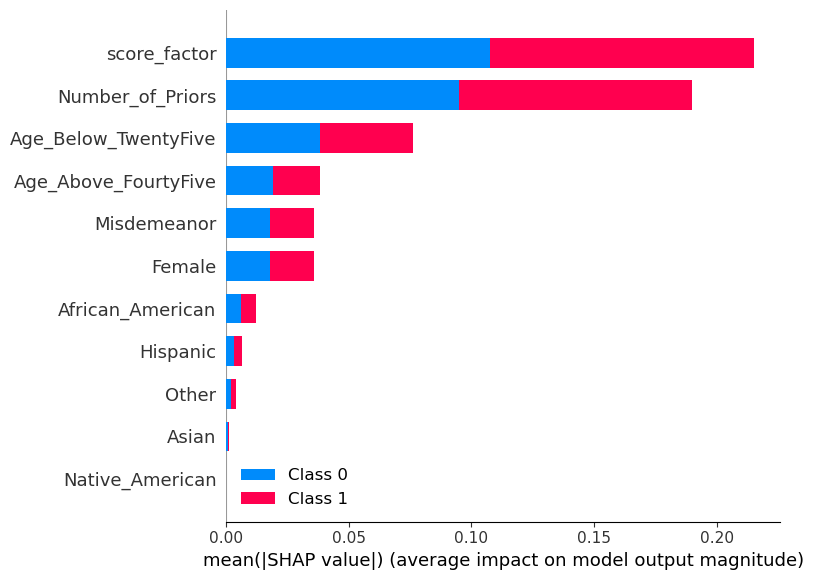

In [18]:
shap.summary_plot(shap_values, data)

> Plot a dependence plot based on a specific field 

Wall time: 102 ms


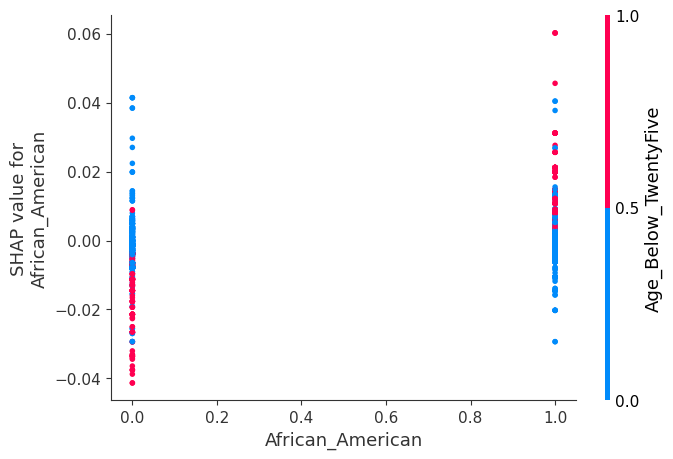

In [20]:
%time shap_values = shap.TreeExplainer(lgbm).shap_values(valid_x)
shap.dependence_plot("African_American", shap_values[1], valid_x)

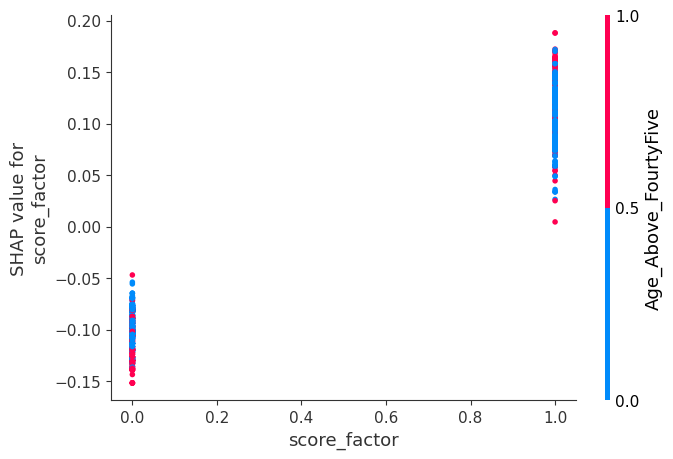

In [21]:
shap.dependence_plot("score_factor", shap_values[1], valid_x)


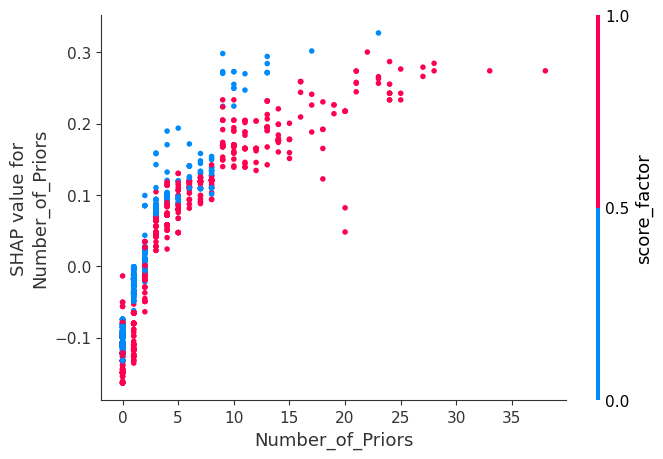

In [22]:
shap.dependence_plot("Number_of_Priors", shap_values[1], valid_x)
